# Homework 2 (Redo)

Name: Syed Zain Raza

## Setup Code

In [28]:
# optional: allow Jupyter to "hot reload" the Python modules I wrote, to avoid restarting the kernel after every change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

from util import ops

In [6]:
dart_img = ops.load_image(
    "./Dartt3.png",
    return_array=True,
    return_grayscale=True,
)

Dimensions of ./Dartt3.png: 556 x 640


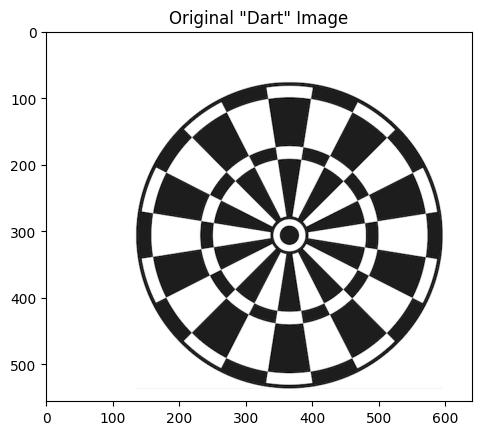

In [15]:
plt.imshow(dart_img, cmap="gray")
plt.title("Original \"Dart\" Image")
plt.show()

## Problem 1: Edge Detection

In [30]:
from util.gaussian_derivative import GaussianDerivativeFilter

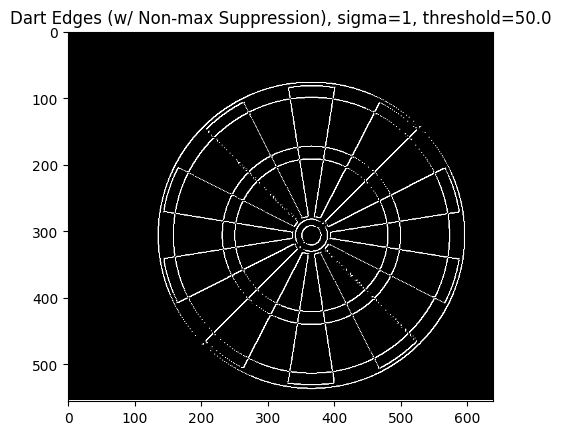

In [12]:
output_image = GaussianDerivativeFilter.detect_edges_and_visualize(
    image=dart_img,
    image_name="Dart",
    sigma=1,  # default
    threshold=50.0,
    use_non_max_suppression=True,
    padding_type="zero",
)

## Center Center Detection

### Problem 2: Hough Transform Voting of Edges Belonging to the Circles 

In [18]:
from util.model_fitting import HoughTransformFitter

In [60]:
from typing import Tuple, Union
import numpy as np

from util import ops
from util.ops import Filter2D


def hough_circle_transform(
    edges_img: np.ndarray,
    orientation_img: np.ndarray,
    plot_title: str,
    radius_interval: Tuple[int, int] = (5, 10),
    voting_threshold: int = 30,
    mode: Union[str, str] = "use_circles",  # or, can be "use_lines"
) -> np.ndarray:
    ### HELPER(S)
    def _find_parallel_vector(
        x: int, y: int, radius: float, theta: float
    ) -> np.ndarray:
        return np.array(
            [x - (radius * np.cos(theta)), y + (radius * np.sin(theta))]
        ).astype(int)

    ### DRIVER
    # Define accumulator array
    radii_range = radius_interval[1] - radius_interval[0]
    accumulator = np.zeros(
        (edges_img.shape[0], edges_img.shape[1], radii_range)
    ).astype(int)

    # Generate a range of radii to consider
    radii = np.arange(start=radius_interval[0], stop=radius_interval[1])

    # Loop over edge pixels
    for y in np.arange(edges_img.shape[0]):
        for x in np.arange(edges_img.shape[1]):
            for r in radii:
                radius_adjusted = r - radius_interval[0]
                edge_pixel = edges_img[y][x]
                # check if it's an edge pixel
                if edge_pixel > 0:
                    angle = orientation_img[y][x]
                    # Vote for possible circle centers
                    vector = None
                    if mode == "use_circles":
                        # find the line containing pixel, in the direction parallel to the gradient
                        vector = _find_parallel_vector(x, y, radius_adjusted, angle)
                    elif mode == "use_lines":
                        # find the line containing pixel, in the direction orthogonal to the gradient
                        perpendicular_rotation = np.array(
                            [
                                [np.cos(angle + np.pi / 2), -np.sin(angle + np.pi / 2)],
                                [np.sin(angle + np.pi / 2), np.cos(angle + np.pi / 2)],
                            ]
                        )
                        orthogonal_vector = np.dot(
                            perpendicular_rotation,
                            _find_parallel_vector(x, y, radius_adjusted, angle),
                        ).astype(int)
                        vector = orthogonal_vector

                    # now make a vote
                    column, row = vector
                    if (-1 < row < accumulator.shape[0]) and (
                        -1 < column < accumulator.shape[1]
                    ):
                        accumulator[row, column, radius_adjusted] += 1
                    else:
                        print(
                            f"Warning: coords ({row}, {column}, {radius_adjusted}) out of bounds for accumulator of shape: ({accumulator.shape})"
                        )

    # find the best radius to try and find the center at
    highest_votes = np.max(accumulator, axis=(0, 1)).squeeze()
    assert (
        highest_votes.shape[0] == accumulator.shape[2]
    ), f"Double check our max() op, it results in a shape mismatch: ({highest_votes.shape}) != ({accumulator.shape[2]})"
    best_radius_index = np.argmax(highest_votes)
    # [TODO] find the proposed center at every radius length
    accumulator_single_radius = accumulator[:, :, best_radius_index]
    # indices = list()
    # apply non-maximum suppression
    # accumulator_max = HoughTransformFitter.non_max_suppression(
    #     accumulator_single_radius
    # )
    accumulator_max = accumulator_single_radius
    assert accumulator_max.shape == (
        accumulator_single_radius.shape
    ), f"Error: double check axis used for Hough transform. Shape mismatch: ({accumulator_max.shape}) != ({accumulator_single_radius.shape})"

    # Find the most likely center
    center_y, center_x = np.where(accumulator_max >= voting_threshold)
    indices_1d = np.argmax(accumulator_max[center_y, center_x])
    indices_2d = np.array(
        ops.convert_1d_indices_to_2d(accumulator_single_radius, indices_1d)
    ).reshape(1, 2)
    assert indices_2d.shape == (
        1,
        2,
    ), f"Error: double check shape of indices. Shape mismatch: ({indices_2d.shape }) != ({(1, 2)})"

    # plot the point
    plt.imshow(dart_img, cmap="gray")
    plt.scatter(y=indices_2d[0, 0], x=indices_2d[0, 1], color="r", s=20)
    plt.title(plot_title)
    plt.show()

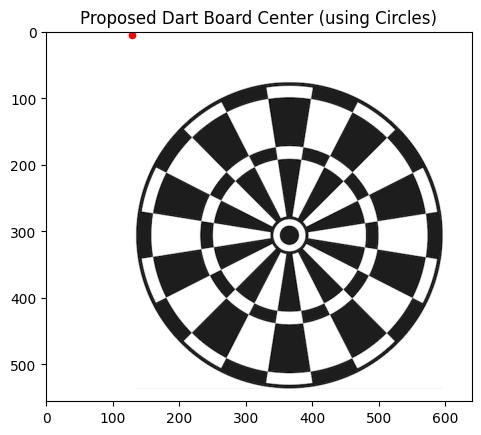

In [61]:
# TODO[debug]
filter = GaussianDerivativeFilter()
(
    partial_derivative_y,
    partial_derivative_x,
) = filter._compute_derivatives(dart_img)
orientation_image = np.arctan2(partial_derivative_y, partial_derivative_x)
hough_circle_transform(
    output_image,
    orientation_image,
    voting_threshold=1,
    plot_title="Proposed Dart Board Center (using Circles)",
    mode="use_circles",  # or, can be "use_lines"
)

### Problem 3: Hough Transform Voting of Edges Belonging to the Straight Lines 

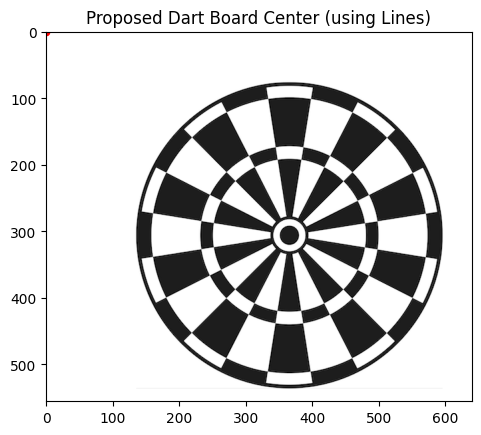

In [59]:
hough_circle_transform(
    output_image,
    orientation_image,
    voting_threshold=1,
    plot_title="Proposed Dart Board Center (using Lines)",
    mode="use_lines",  # or, can be "use_lines"
)